# Exploring the M-particles model with elastic energy landscape for RuvB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from os.path import exists
from matplotlib import cm
from matplotlib import ticker
from matplotlib.ticker import FixedLocator, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numba import jit, prange, njit
from time import time as Clock
from decimal import Decimal
from numpy.linalg import eig
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit as fit
from itertools import permutations

In [2]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import string
#print(rcParams.keys())

WIDTH = 3+3/8
TICK_SIZE = 6
FONT_SIZE = 8
LEGEND_SIZE = 6
TITLE_SIZE = 8

plt.rc("font", size = FONT_SIZE)
plt.rc("figure", titlesize = TITLE_SIZE)
plt.rc("xtick", labelsize = TICK_SIZE)
plt.rc("ytick", labelsize = TICK_SIZE)
plt.rc("axes", titlesize = TITLE_SIZE, labelsize = FONT_SIZE)
plt.rc("legend", fontsize = LEGEND_SIZE, frameon = False)

## Coupling terms

In [3]:
@jit(nopython = True)
def coupling(x, xp1, xm1, L, spring_k, spring_l):
    d = xp1 - x - spring_l
    E = spring_k/2*(1 - np.cos(2*np.pi*d/L))
    
    d = x - xm1 - spring_l
    E += spring_k/2*(1 - np.cos(2*np.pi*d/L))
    
    return E

@jit(nopython = True)
def dcouplingdx(x, xp1, xm1, L, spring_k, spring_l):
    d = xp1 - x - spring_l
    dEdx = -spring_k*np.sin(2*np.pi*d/L)*np.pi/L
    
    d = x - xm1 - spring_l
    dEdx += spring_k*np.sin(2*np.pi*d/L)*np.pi/L
    
    return dEdx

@jit(nopython = True)
def asym_coupling(state, M, N, spring_k, spring_l):
    E_k = np.zeros(M)
    for m in range(M):
        dist = state[(m+1)%M] - state[m] - spring_l
        
        E_k[m] = spring_k/2*(1 - np.cos(dist*np.pi/(N/2)))
        
    E = np.sum(E_k)/M
    return E

@jit(nopython = True)
def asym_coupling_split(state, M, N, spring_k, spring_l):
    Ef = np.zeros(M)
    Eb = np.zeros(M)
    for m in range(M):
        dist = state[(m+1)%M] - state[m] - spring_l
        Ef[m] = spring_k/2*(1 - np.cos(dist*np.pi/(N/2)))
        
        dist = state[m] - state[(m-1)%M] - spring_l
        Eb[m] = spring_k/2*(1 - np.cos(dist*np.pi/(N/2)))
        
    return Ef/(2*M), Eb/(2*M)



## Non-equilibrium energy

In [4]:
@jit(nopython = True)
def perturb_gillespie(coord, N, M, offset, perturb_index, perturb_energy):    
    ks = np.ones(2*M)
    
    for i in range(M):
        offset_index = (coord[i] + offset*i) % N
        if perturb_index[offset_index, 0]:
            ks[2*i] = np.exp(perturb_energy[offset_index, 0])
        if perturb_index[offset_index, 1]:
            ks[2*i + 1] = np.exp(-perturb_energy[offset_index, 1])
            
    return ks
        

## Auxiliary functions

In [5]:
def prob_marginal(p, nbins, M, m = 0):
    p = p.reshape(np.array([nbins for i in range(M)]))
    
    if M != 1:
        ms = np.arange(M)
        ms = tuple(ms[ms != m])
        marginal_p = np.sum(p, axis = ms)
    else:
        marginal_p = p
    
    return marginal_p/np.sum(marginal_p)

@jit(nopython = True)
def energy_state_gillespie(state, energy, offset, spring_k, spring_l):
    M = len(state)
    N = len(energy)
    
    E = asym_coupling(state, M, N, spring_k, spring_l)
    V = sum([energy[(state[m] + offset*m)%N] for m in range(M)])
    
    return E+V


@jit(nopython = True)
def prob_matrix_gillespie(x, energy, M, kT = 1, offset = 0, spring_k = 10, spring_l = 0):
    N = len(x)
    E_tot = np.zeros(N**M, dtype = np.float64)
    
    idx = np.zeros(M, dtype = np.int_)

    for k in range(N**M):
        K = k
        for m in range(M):
            idx[m] = K % N
            K = K // N
        
        E_tot[k] = energy_state_gillespie(idx, energy, offset, spring_k, spring_l)

    p = np.exp(-E_tot/kT)
    return p


@jit(nopython = True)
def W_matrix(prob_matrix, N, M):
    W = np.zeros((N**M, N**M))
    
    idx = np.zeros(M, dtype = np.int_)
    factor = np.array([N**m for m in range(M)])
    for k in range(N**M):
        K = k
        for m in range(M):
            idx[m] = K % N
            K = K // N
        
        for m in range(M):
            i = idx[m]
            for i_ in [(i-1)%N, (i+1)%N]:
                idx_ = np.copy(idx)
                idx_[m] = i_
                k_ = int(np.sum(idx_*factor))
                
                delta = (prob_matrix[k]/prob_matrix[k_])**0.5
                W[k, k_] = delta
                
            
    for k in range(N**M):
        W[k,k] = - np.sum(W[:,k])

    return W


@jit(nopython = True)
def occupancy_gillespie(trajectory, time, N, M):
    freq = np.zeros(N**M)
    factor = np.array([N**m for m in range(M)])
    
    t = time[1:] - time[:-1]
    for i in range(len(time)-1):
        k = int(np.sum(trajectory[:, i]*factor))
        freq[k] += t[i]
    freq /= np.sum(freq)
    return freq

## Gillespie trajectories

In [6]:
@jit(nopython = True)
def next_step_rates(old_coord, r, kT, N, M, offset,
                    energy, spring_k, spring_l, tau,
                    perturb_index, perturb_energy):  
    
    new_coord = np.zeros((2*M, M), dtype = np.int_)
    effective_tau = np.zeros((2*M), dtype = np.float_)
    
    for m in range(M):
        i = old_coord[m]
        
        # Assign same position to the possible next states
        new_coord[2*m] = old_coord
        new_coord[2*m + 1] = old_coord
        
        # Change only the position of mth particle
        new_coord[2*m, m] = (i+1)%N
        new_coord[2*m + 1, m] = (i-1)%N
        
        # Calculate the effective tau
        effective_tau[2*m] = (tau[i] + tau[(i+1)%N]) / 2
        effective_tau[2*m + 1] = (tau[i] + tau[(i-1)%N]) / 2
            
    # Calculate rates from conservative energies
    ks = np.zeros(2*M)
    old_energy = energy_state_gillespie(old_coord, energy, offset, spring_k, spring_l)
    
    for m2 in range(2*M):
        new_energy = energy_state_gillespie(new_coord[m2], energy, offset, spring_k, spring_l)
        delta = np.exp((old_energy - new_energy)/(2*kT))
        
        ks[m2] = delta / (delta + 1/delta)
        ks[m2] = ks[m2] / effective_tau[m2]
        
    # Energetic contribution from  perturbation
    if np.sum(perturb_index**2) != 0:
        non_eq_rate = perturb_gillespie(old_coord, N, M, offset, 
                              perturb_index, perturb_energy)
        ks *= non_eq_rate
    
    
    t = -np.log(r[0])/(np.sum(ks))
    
    c = 0
    cycle = np.zeros(M)
    for m2 in range(2*M):
        c += ks[m2]/np.sum(ks)
        if r[1] < c:
            if new_coord[m2, m2//2] == 0 and old_coord[m2//2] == N-1:
                cycle[m2//2] = 1
            elif new_coord[m2, m2//2] == N-1 and old_coord[m2//2] == 0:
                cycle[m2//2] = -1
            
            return new_coord[m2], t, cycle
        

def trajectory(x, energy, rep, i0, precalculate_W = True,
               offset = 0, spring_k = 10, spring_l = 0,
               kT = 1, seed = 14, tau = None,
               perturb_index = None, perturb_energy = None):
    
    M = len(i0)
    N = len(energy)
    traj = np.zeros((rep, M), dtype = np.int_)
    time = np.zeros(rep)
    cycle = np.zeros((rep, M))
    
    if type(perturb_index) == type(None):
        perturb_index = np.zeros((len(energy), 2))
        perturb_energy = np.zeros((len(energy), 2))
    
    if type(tau) == type(None):
        tau = np.ones(len(energy))
    
    np.random.seed(seed)
    random = np.random.uniform(size = (rep, 2))
    traj[0] = i0
    
    @jit(nopython = True)
    def helper(traj, time, cycle):
        for r in range(1, rep):
            i, t, c = next_step_rates(traj[r-1, :], random[r], kT, N, M, offset,
                                      energy, spring_k, spring_l, tau,
                                      perturb_index, perturb_energy)

            time[r] = time[r-1] + t
            for m in range(M):
                cycle[r, m] = cycle[r-1, m] + c[m]
            traj[r, :] = i
            
        return traj.T, time.T, cycle.T
    
    return helper(traj, time, cycle)

## Coupling energy and coupling force per conformation

In [7]:
@jit(nopython = True)
def coupling_per_state(trajectory, spring_k = 100, spring_l = 5, N = 30):
    M = trajectory.shape[0]
    
    E_fwd = np.zeros(N)
    E_bwd = np.zeros(N)
    count = np.zeros(N)
    
    for m in range(M):
        bwd = trajectory[m]
        fwd = trajectory[(m+1)%M]
        
        dist = fwd - bwd - spring_l
        energy = spring_k/(2*M)*(1 - np.cos(dist*np.pi/(N/2)))
        
        for i in range(trajectory.shape[1]):
            E_fwd[fwd[i]] += energy[i]
            E_bwd[bwd[i]] += energy[i]

            count[fwd[i]] += 1
            
            
    return E_fwd/count, E_bwd/count

@jit(nopython = True)
def coupling_traj(trajectory, spring_k = 100, spring_l = 5, N = 30):
    M = trajectory.shape[0]
    niter = trajectory.shape[1]
    
    E_cpl = np.zeros(niter)
    
    for m in range(M):
        bwd = trajectory[m]
        fwd = trajectory[(m+1)%M]
        
        dist = fwd - bwd - spring_l
        energy = spring_k/(2*M)*(1 - np.cos(dist*np.pi/(N/2)))
        
        E_cpl += energy
            
    return E_cpl


@jit(nopython = True)
def force_per_state(trajectory, spring_k = 100, spring_l = 5, N = 30):
    M = trajectory.shape[0]
    
    F_fwd = np.zeros(N)
    F_bwd = np.zeros(N)
    count = np.zeros(N)
    
    for m in range(M):
        bwd = trajectory[m]
        fwd = trajectory[(m+1)%M]
        
        dist = fwd - bwd - spring_l
        energy = spring_k/(2*M)*(1 - np.cos(dist*np.pi/(N/2)))
        force = -spring_k/(2*M)*np.sin(dist*np.pi/(N/2))*np.pi/(N/2)
        
        for i in range(trajectory.shape[1]):
            F_fwd[fwd[i]] += force[i]
            F_bwd[bwd[i]] -= force[i]

            count[fwd[i]] += 1
            
            
    return F_fwd/count, F_bwd/count

@jit(nopython = True)
def force_traj(trajectory, spring_k = 100, spring_l = 5, N = 30):
    M = trajectory.shape[0]
    niter = trajectory.shape[1]
    
    F_cpl = np.zeros(niter)
    
    for m in range(M):
        bwd = trajectory[m]
        fwd = trajectory[(m+1)%M]
        
        dist = fwd - bwd - spring_l
        energy = spring_k/(2*M)*(1 - np.cos(dist*np.pi/(N/2)))
        force = -spring_k/(2*M)*np.sin(dist*np.pi/(N/2))*np.pi/(N/2)
        
        F_cpl += force    
            
    return F_cpl


# Trajectory simulation

8.204514741897583


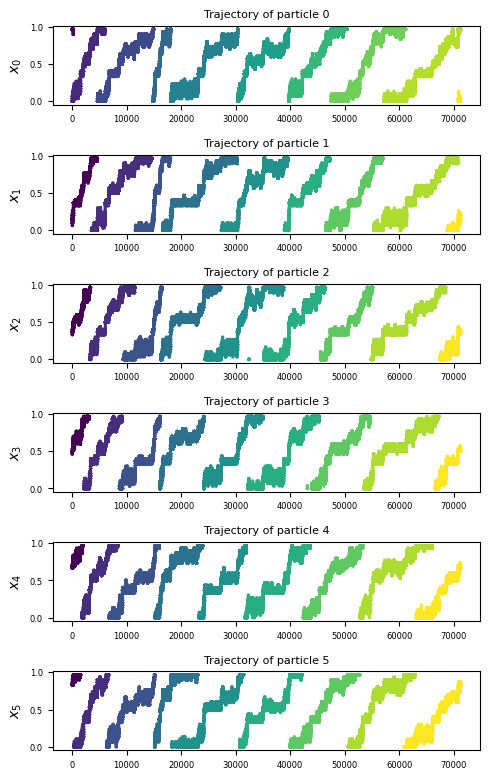

In [8]:
t1 = Clock()

N = 30
M = 6
init = np.arange(0, 30, 5)

x = np.linspace(0, 1, N+1)[:N]
V = np.load("energy_landscape.npy")

perturb_index2 = np.zeros((len(V), 2))
perturb_index2[10, 0] = 1
perturb_energy2 = np.zeros((len(V), 2))
perturb_energy2[10, 0] = 20

tau = np.ones(len(V))
tau[10:30] = 10

traj, time, cycle = trajectory(x, V, 100000, init, False,
                               spring_k = 150, spring_l = 5,
                               seed = 41, kT = 1, tau = tau,
                               perturb_index = perturb_index2,
                               perturb_energy = perturb_energy2)

print(Clock() - t1)



fig = plt.figure(figsize = (5,1.5*M), dpi = 100)

for m in range(M):
    ax = fig.add_subplot(M+1, 1, m+1)
    ax.set_title("Trajectory of particle " + str(m))
    ax.set_ylabel("$x_"+str(m)+"$", fontsize = 10)
    ax.scatter(time, x[traj[m]], s = 2, c = cycle[m])

plt.tight_layout()

# Han data


In [9]:
def michaelis_menten(concentration, Km, vmax):
    return vmax*concentration/(Km + concentration)

[9.27515919e-05 3.21771208e+00]
[4.75868446e-05 7.51009217e+00]


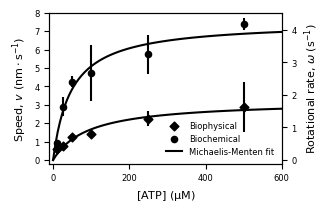

In [10]:
fig = plt.figure(figsize = (3,2), dpi = 100)
ax = fig.add_subplot(1,1,1)

# experimental data [Han et al., 2006] digitized with https://apps.automeris.io/wpd/
# Paper: 8.3 bp/s and Km 65 uM
# Our fitting: Km = 93e-6M and Vmax = 9.5bp/s

experimental_ATP = np.array([10e-6, 25e-6, 50e-6, 100e-6, 250e-6, 500e-6])
biophys_speed = np.array([1.7, 2.3, 3.6, 4.2, 6.6, 8.4])*0.34   #1bp = 0.34nm
biophys_error = np.array([0.4, 0.4, 0.4, 0.4, 1.2, 4])*0.34 #1bp = 0.34nm
biophys_params, _ = fit(michaelis_menten, experimental_ATP, biophys_speed)
print(biophys_params)


# Paper: "These results provide a Km value of 35 μM and a Vmax of 20 bp/s"
# Our fitting: Km = 48e-6 M and Vmax = 22.1 bp/s
biochem_speed = np.array([2.7, 8.5, 12.5, 13.9, 16.9, 21.7])*0.34   #1bp = 0.34nm
biochem_error = np.array([0.4, 1.5, 0.9, 4.5, 3.1, 1])*0.34 #1bp = 0.34nm
biochem_params, _ = fit(michaelis_menten, experimental_ATP, biochem_speed)
print(biochem_params)

atp = np.linspace(0, 6e-4, 100)

ax.scatter(experimental_ATP, biophys_speed, s = 20, color = "black", marker = "D", label = "Biophysical")
ax.errorbar(experimental_ATP, biophys_speed, biophys_error, color = "black", fmt = "none")
ax.plot(atp, michaelis_menten(atp, *biophys_params), color = "black")
#plt.axhline(biophys_params[1], color = "black")

ax.scatter(experimental_ATP, biochem_speed, s = 20, color = "black", marker = "o", label = "Biochemical")
ax.errorbar(experimental_ATP, biochem_speed, biochem_error, color = "black", fmt = "none")
ax.plot(atp, michaelis_menten(atp, *biochem_params), color = "black", label = "Michaelis-Menten fit")
#plt.axhline(biochem_params[1], color = "black")

ax.set_xlim(-1e-5, 6e-4)
ax.set_ylim(-.2, 8)
ax.set_xticks([0, 2e-4, 4e-4, 6e-4], [0, 200, 400, 600])
ax.set_xlabel("[ATP] ($\\rm \\mu M$)")
ax.set_ylabel("Speed, $v$ ($\\rm nm \cdot s^{-1}$)")

ax.legend()
ax = ax.twinx()
ax.set_yticks(np.arange(5)*5.2*0.34, np.arange(5))

ax.set_ylabel("Rotational rate, $\omega$ ($\\rm s^{-1}$)")
ax.set_xlim(-1e-5, 6e-4)
ax.set_ylim(-.2, 8)
plt.show()


# Calibrate $\tau_{\rm F}$ using biochemical data [Han et al., 2006] for different $k$

### dataset A


tau without drag
0.001132673181179109
0.0010584301679427888
0.0009245303292268417
0.0008397032894141748
0.0007716414925437912
0.0007174323060840467
0.0006629358409124649
0.0006021687801445345
0.000536953595581002


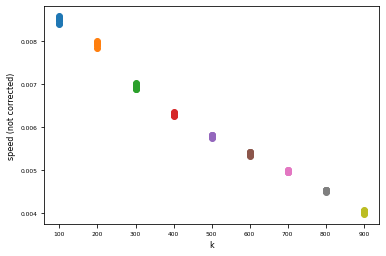

In [11]:
nrep = 10

ks = np.arange(1, 10, 1)
speed = np.zeros((len(ks), nrep))

for i in range(len(ks)):
    for j in range(nrep):
        speed[i] = np.load("simulations/datasetA/mu500_k" + str(ks[i]) + "00_speed.npy")    

for i in range(len(ks)):
    plt.scatter(np.ones(nrep)*ks[i]*100, speed[i])

plt.xlabel("k")
plt.ylabel("speed (not corrected)")
print("\ntau without drag")
for i in range(len(ks)):
    print(np.mean(speed[i]) / biochem_params[1])

# Calibrate $\tau_{\rm B}$ using biophysical data [Han et al., 2006] for different $k$

### dataset B

In [12]:
nrep = 10

ks = np.arange(1, 10, 1)
ratio = np.arange(1, 11, 1)
speed = np.zeros((len(ks), len(ratio), nrep))

for i in range(len(ks)):
    for j in range(len(ratio)):
        speed[i, j] = np.load("simulations/datasetB/mu500_k" + str(ks[i]) + "00_tauR" + str(ratio[j]) + "_speed.npy")    


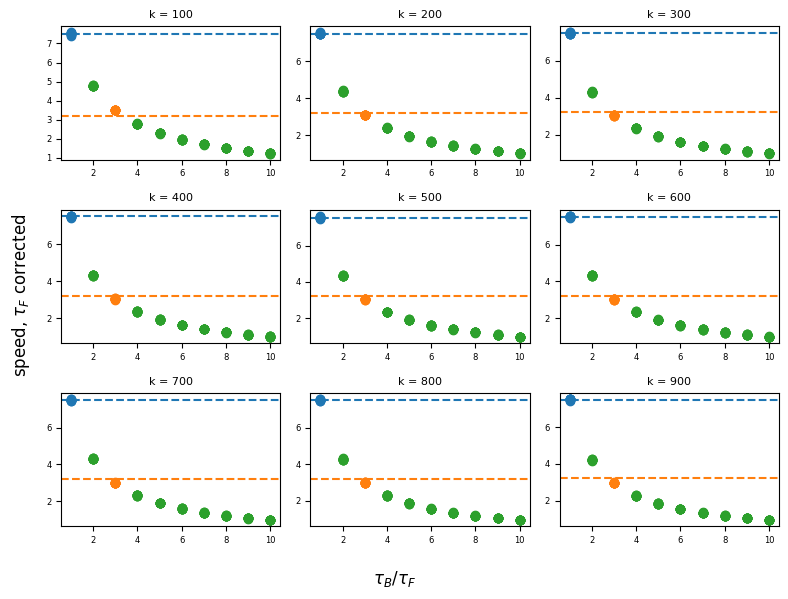

In [14]:
fig = plt.figure(figsize = (8, 6), dpi = 100)

color = ["C0", "C2", "C1"] + ["C2"] * 7
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    for j in range(len(ratio)):
        plt.scatter(np.ones(nrep) * ratio[j],
                    speed[i, j], color = color[j])
        
    plt.axhline(biochem_params[1], color = "C0", linestyle = "dashed")
    plt.axhline(biophys_params[1], color = "C1", linestyle = "dashed")
    plt.title("k = " + str(ks[i]*100))
        
fig.supxlabel("$\\tau_B / \\tau_F$")
fig.supylabel("speed, $\\tau_F$ corrected")
plt.tight_layout()

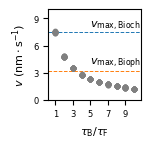

In [15]:
fig = plt.figure(figsize = (1.2, 1.2), dpi = 100)

ax = fig.add_subplot()
for j in range(len(ratio)):
    plt.scatter(np.ones(nrep) * ratio[j],
                speed[0, j], color = "gray", s = 10)

plt.text(5, biochem_params[1], "$v_{\\rm max, Bioch}$", va = "bottom", size = 8)
plt.text(5, biophys_params[1], "$v_{\\rm max, Bioph}$", va = "bottom", size = 8)
plt.axhline(biochem_params[1], color = "C0", linestyle = "dashed", zorder = -1, lw = .7)
plt.axhline(biophys_params[1], color = "C1", linestyle = "dashed", zorder = -1, lw = .7)
        
plt.xlabel("$\\tau_{\\rm B} / \\tau_{\\rm F}$")
plt.xticks([1, 3, 5, 7, 9])
plt.xlim(0.2, 10.8)

plt.ylabel("$v$ $(\\rm nm \cdot s^{-1})$")
plt.ylim(0, 10)
plt.yticks([0, 3, 6, 9])
plt.show()

# Plot $\Delta \mu$ x $v$ curves for different $k$

### dataset C

## $v(x) = v_{max} \frac{x}{K_M + x}$

where $v$ is the speed of the reaction, $x$ is the concentration of ATP, $K_M$ is the Michaelis-Menten constant, and $v_{max}$ is the observed maximum speed of reaction.

### $ v (K_M + x) = v_{max} x$
### $v K_M + v x = v_{max} x$
### $x (v_{max} - v) = v K_M$
### $x = K_M \frac{v}{v_{max} - v}$

Using the definition of chemical potential
### $\Delta \mu = kT\log(x/c)$
### $x = c \exp \left( \frac{\Delta \mu}{kT} \right)$

And replacing in the rearranged Michaelis-Menten equation
### $c\exp(\frac{\Delta \mu}{kT}) = K_M \frac{v}{v_{max} - v}$
### $\frac{\Delta \mu}{kT} = \log \left(\frac{K_M}{c} \frac{v}{v_{max} - v} \right)$
### $\frac{\Delta \mu}{kT} = b + \log \left(K_M \frac{v}{v_{max} - v} \right)$

In [23]:
def michaelis_menten_biochem(v, b):
    Km, max_speed = biochem_params
    return b + np.log((v * Km) / (max_speed - v))

def michaelis_menten_biophys(v, b):
    Km, max_speed = biophys_params
    return b + np.log((v * Km) / (max_speed - v))

In [26]:
nrep = 5
nmus = 20

ks = np.arange(1, 10, 1)
speed_biochem = np.zeros((len(ks), nmus, nrep))
speed_biophys = np.zeros((len(ks), nmus, nrep))

for i in range(len(ks)):
    for j in range(nmus):
        speed_biochem[i, j] = np.load("simulations/datasetC/mu" + str(j) + "_k" + str(ks[i]) + "00_tauR1_speed.npy")    
        speed_biophys[i, j] = np.load("simulations/datasetC/mu" + str(j) + "_k" + str(ks[i]) + "00_tauR3_speed.npy")    


100 14.53602278034023
200 17.106613050525272
300 17.381765013087946
400 17.631062574069205
500 19.88520564171111
600 20.197263405873343
700 20.505071918835977
800 20.799917772096677
900 21.051186840200558


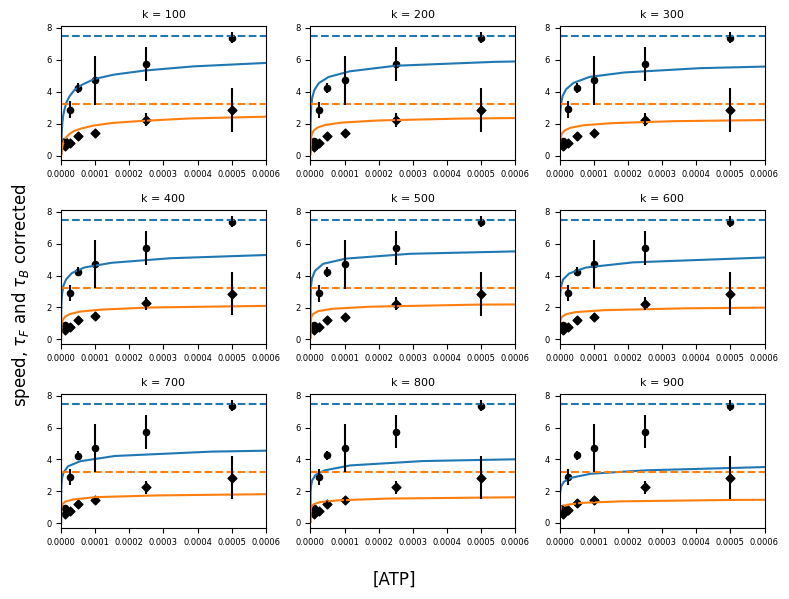

In [27]:
fig = plt.figure(figsize = (8, 6), dpi = 100)

for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    plt.title("k = " + str(ks[i]*100))

    if i == 0:
        mus = np.linspace(0.2, 9, nmus)
    elif i <= 3:
        mus = np.linspace(0.3, 15, nmus)
    else:
        mus = np.linspace(0.4, 20, nmus)
    
    
    # Fitting for tau ratio = 1, biochem
    mean_speed = np.mean(speed_biochem[i], axis = 1)
    params, _ = fit(michaelis_menten_biochem, 
                    mean_speed, mus, 
                    bounds = (0, np.inf))
    
    atp_conc = np.exp(mus - params[0])
    print(str(ks[i]*100), params[0])
    
    plt.plot(atp_conc, mean_speed, color = "C0")
    plt.axhline(biochem_params[1], color = "C0", linestyle = "dashed")
    
    
    # Fitting for tau ratio = 3, biophys
    mean_speed = np.mean(speed_biophys[i], axis = 1)
    params, _ = fit(michaelis_menten_biophys, 
                    mean_speed, mus, 
                    bounds = (0, np.inf))
    
    atp_conc = np.exp(mus - params[0])

    plt.plot(atp_conc, mean_speed, color = "C1")
    plt.axhline(biophys_params[1], color = "C1", linestyle = "dashed")
    
    
    # Experimental
    ax.scatter(experimental_ATP, biophys_speed, s = 20, color = "black", marker = "D")
    ax.errorbar(experimental_ATP, biophys_speed, biophys_error, color = "black", fmt = "none")
    
    ax.scatter(experimental_ATP, biochem_speed, s = 20, color = "black", marker = "o")
    ax.errorbar(experimental_ATP, biochem_speed, biochem_error, color = "black", fmt = "none")
    plt.xlim(0, 0.0006)

            
fig.supxlabel("[ATP]")
fig.supylabel("speed, $\\tau_F$ and $\\tau_B$ corrected")
plt.tight_layout()

# Simulated trajectories

/tmp/ipykernel_17763/2892287569.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_particles = cm.get_cmap("Blues", 7)


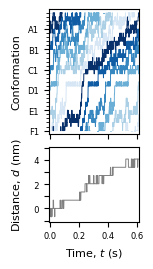

In [28]:
N = 30
M = 6
k = 100

x = np.linspace(0, 1, N+1)[:N]
V = np.load("energy_landscape.npy")
init = np.arange(0, 30, 5)

mu_ATP = 20
perturb_index = np.zeros((N, 2))
perturb_index[10, 0] = 1
perturb_index[11, 1] = 1
perturb_index[13, 0] = 1
perturb_index[14, 1] = 1

perturb_energy = perturb_index * mu_ATP / np.sum(perturb_index)

tauF = 0.001132673181179109
tau = np.ones(len(V)) * tauF
x = np.linspace(0, 1, N+1)[:N]

traj, time, cycle = trajectory(x, V, 100000, init, False,
                               spring_k = k, spring_l = 5,
                               seed = 0, kT = 1, tau = tau,
                               perturb_index = perturb_index,
                               perturb_energy = perturb_energy)

fig = plt.figure(figsize=(1., 2.5), dpi=100)
ax = fig.add_axes([.05, .4, .9, .5])

color_particles = cm.get_cmap("Blues", 7)

iter_max = 3000
traj_ = traj[:, :iter_max]
time_ = time[:iter_max]
cycle_ = cycle[:, :iter_max]

for m in range(M):
    boundary = np.where(np.abs(traj_[m, :-1] - traj_[m, 1:]) > 1)[0]
    
    ax.plot(time_[:boundary[0]+1], 
            traj_[m][:boundary[0]+1], 
            label = "Particle " + str(m+1), 
            color = color_particles(m+1),
            lw = .7)
    
    for i in range(len(boundary)-1):
        rang = range(boundary[i]+1, boundary[i+1])
        ax.plot(time_[rang], 
                traj_[m][rang], 
                color = color_particles(m+1),
                lw = .7)
    
    ax.plot(time_[boundary[-1]+1:], 
            traj_[m][boundary[-1]+1:], 
            color = color_particles(m+1),
            lw = .7)
        
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_yticks(range(0, 30, 5), ["F1", "E1", "D1", "C1", "B1", "A1"])
ax.set_ylim(-.9, 29.9)
ax.set_xticks([0, .2, .4, .6], [""]*4)
ax.set_xlim(-.01, 0.61)
ax.set_ylabel("Conformation")


ax = fig.add_axes([.05, .05, .9, .3])
ax.plot(np.nan, np.nan, lw = .7, color = color_particles(5), label = "Monomers")
ax.plot(time_, np.sum(cycle_, axis = 0)*2*0.34, 
        lw = .7, color = "gray", label = "Hexamer")

ax.set_xticks([0, .2,  .4, .6])
ax.set_xlim(-.01, 0.61)
ax.set_yticks([-1, 0, 1, 2, 3, 4, 5], ["   ", "  0", "   ", "  2", "   ", "  4", "   "])
ax.set_ylim(-1.1, 5.1)
ax.set_ylabel("Distance, $d$ (nm)")
ax.set_xlabel("Time, $t$ (s)")

#ax.legend()

plt.show()

# Trajectory with arbitrary time

/tmp/ipykernel_17763/2894135187.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_particles = cm.get_cmap("Greys", 7)


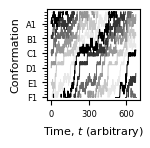

In [29]:
N = 30
M = 6
k = 100

x = np.linspace(0, 1, N+1)[:N]
V = np.load("energy_landscape.npy")
init = np.arange(0, 30, 5)

mu_ATP = 500
perturb_index = np.zeros((N, 2))
perturb_index[10, 0] = 1
perturb_index[11, 1] = 1
perturb_index[13, 0] = 1
perturb_index[14, 1] = 1

perturb_energy = perturb_index * mu_ATP / np.sum(perturb_index)

tauF = 1
tau = np.ones(len(V)) * tauF
x = np.linspace(0, 1, N+1)[:N]

traj, time, cycle = trajectory(x, V, 100000, init, False,
                               spring_k = k, spring_l = 5,
                               seed = 0, kT = 1, tau = tau,
                               perturb_index = perturb_index,
                               perturb_energy = perturb_energy)

fig = plt.figure(figsize=(1.2, 1.2), dpi=100)
ax = fig.add_subplot()

color_particles = cm.get_cmap("Greys", 7)

iter_max = 3000
traj_ = traj[:, :iter_max]
time_ = time[:iter_max]
cycle_ = cycle[:, :iter_max]

for m in range(M):
    boundary = np.where(np.abs(traj_[m, :-1] - traj_[m, 1:]) > 1)[0]
    
    ax.plot(time_[:boundary[0]+1], 
            traj_[m][:boundary[0]+1], 
            label = "Particle " + str(m+1), 
            color = color_particles(m+1),
            lw = .7)
    
    for i in range(len(boundary)-1):
        rang = range(boundary[i]+1, boundary[i+1])
        ax.plot(time_[rang], 
                traj_[m][rang], 
                color = color_particles(m+1),
                lw = .7)
    
    ax.plot(time_[boundary[-1]+1:], 
            traj_[m][boundary[-1]+1:], 
            color = color_particles(m+1),
            lw = .7)
        
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_yticks(range(0, 30, 5), ["F1", "E1", "D1", "C1", "B1", "A1"])
ax.set_ylim(-.9, 29.9)
ax.set_xticks([0, 300, 600])
ax.set_xlabel("Time, $t$ (arbitrary)")
#ax.set_xticks([0, .2, .4, .6], [""]*4)
#ax.set_xlim(-.01, 0.61)
ax.set_ylabel("Conformation")

plt.show()

# Trajectory with $\tau_{\rm F}$

/tmp/ipykernel_17763/3892005864.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_particles = cm.get_cmap("Blues", 7)


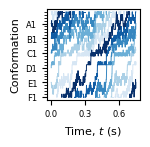

In [30]:
N = 30
M = 6
k = 100

x = np.linspace(0, 1, N+1)[:N]
V = np.load("energy_landscape.npy")
init = np.arange(0, 30, 5)

mu_ATP = 500
perturb_index = np.zeros((N, 2))
perturb_index[10, 0] = 1
perturb_index[11, 1] = 1
perturb_index[13, 0] = 1
perturb_index[14, 1] = 1

perturb_energy = perturb_index * mu_ATP / np.sum(perturb_index)

tauF = 0.001132673181179109
tau = np.ones(len(V)) * tauF
x = np.linspace(0, 1, N+1)[:N]

traj, time, cycle = trajectory(x, V, 100000, init, False,
                               spring_k = k, spring_l = 5,
                               seed = 1, kT = 1, tau = tau,
                               perturb_index = perturb_index,
                               perturb_energy = perturb_energy)

fig = plt.figure(figsize=(1.2, 1.2), dpi=100)
ax = fig.add_subplot()

color_particles = cm.get_cmap("Blues", 7)

iter_max = 3000
traj_ = traj[:, :iter_max]
time_ = time[:iter_max]
cycle_ = cycle[:, :iter_max]

for m in range(M):
    boundary = np.where(np.abs(traj_[m, :-1] - traj_[m, 1:]) > 1)[0]
    
    ax.plot(time_[:boundary[0]+1], 
            traj_[m][:boundary[0]+1], 
            label = "Particle " + str(m+1), 
            color = color_particles(m+1),
            lw = .7)
    
    for i in range(len(boundary)-1):
        rang = range(boundary[i]+1, boundary[i+1])
        ax.plot(time_[rang], 
                traj_[m][rang], 
                color = color_particles(m+1),
                lw = .7)
    
    ax.plot(time_[boundary[-1]+1:], 
            traj_[m][boundary[-1]+1:], 
            color = color_particles(m+1),
            lw = .7)
        
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_yticks(range(0, 30, 5), ["F1", "E1", "D1", "C1", "B1", "A1"])
ax.set_ylim(-.9, 29.9)
ax.set_xticks([0, .3, .6])
ax.set_xlabel("Time, $t$ (s)")
#ax.set_xticks([0, .2, .4, .6], [""]*4)
#ax.set_xlim(-.01, 0.61)
ax.set_ylabel("Conformation")

plt.show()

# Trajectory with $\tau_{\rm F}$ and $\tau_{\rm B}$

/tmp/ipykernel_17763/603134536.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_particles = cm.get_cmap("Oranges", 7)


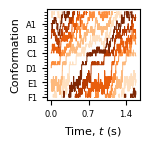

In [31]:
N = 30
M = 6
k = 100

x = np.linspace(0, 1, N+1)[:N]
V = np.load("energy_landscape.npy")
init = np.arange(0, 30, 5)

mu_ATP = 500
perturb_index = np.zeros((N, 2))
perturb_index[10, 0] = 1
perturb_index[11, 1] = 1
perturb_index[13, 0] = 1
perturb_index[14, 1] = 1

perturb_energy = perturb_index * mu_ATP / np.sum(perturb_index)

tauF = 0.001132673181179109
tauB = tauF*3
tau = np.ones(len(V)) * tauF
tau[10:30] = tauB
x = np.linspace(0, 1, N+1)[:N]

traj, time, cycle = trajectory(x, V, 100000, init, False,
                               spring_k = k, spring_l = 5,
                               seed = 2, kT = 1, tau = tau,
                               perturb_index = perturb_index,
                               perturb_energy = perturb_energy)

fig = plt.figure(figsize=(1.2, 1.2), dpi=100)
ax = fig.add_subplot()

color_particles = cm.get_cmap("Oranges", 7)

iter_max = 3000
traj_ = traj[:, :iter_max]
time_ = time[:iter_max]
cycle_ = cycle[:, :iter_max]

for m in range(M):
    boundary = np.where(np.abs(traj_[m, :-1] - traj_[m, 1:]) > 1)[0]
    
    ax.plot(time_[:boundary[0]+1], 
            traj_[m][:boundary[0]+1], 
            label = "Particle " + str(m+1), 
            color = color_particles(m+1),
            lw = .7)
    
    for i in range(len(boundary)-1):
        rang = range(boundary[i]+1, boundary[i+1])
        ax.plot(time_[rang], 
                traj_[m][rang], 
                color = color_particles(m+1),
                lw = .7)
    
    ax.plot(time_[boundary[-1]+1:], 
            traj_[m][boundary[-1]+1:], 
            color = color_particles(m+1),
            lw = .7)
        
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_yticks(range(0, 30, 5), ["F1", "E1", "D1", "C1", "B1", "A1"])
ax.set_ylim(-.9, 29.9)
ax.set_xticks([0, .7, 1.4])
ax.set_xlabel("Time, $t$ (s)")
#ax.set_xticks([0, .2, .4, .6], [""]*4)
#ax.set_xlim(-.01, 0.61)
ax.set_ylabel("Conformation")

plt.show()

# Curve fit of Speed-[ATP] data

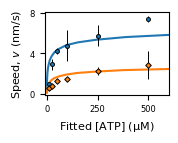

In [33]:
nrep = 5
nmus = 20

speed_biochem = np.zeros((nmus, nrep))
speed_biophys = np.zeros((nmus, nrep))

for j in range(nmus):
    speed_biochem[j] = np.load("simulations/datasetC/mu" + str(j) + "_k100_tauR1_speed.npy")    
    speed_biophys[j] = np.load("simulations/datasetC/mu" + str(j) + "_k100_tauR3_speed.npy")    

fig = plt.figure(figsize=(1.6, 1.1), dpi=100)
ax = fig.add_subplot(1, 1, 1)

mus = np.linspace(0.2, 9, nmus)


# Fitting for tau ratio = 1, biochem
mean_speed = np.mean(speed_biochem, axis = 1)
params, _ = fit(michaelis_menten_biochem, 
                mean_speed, mus, 
                bounds = (0, np.inf))

atp_conc = np.exp(mus - params[0])
plt.plot(atp_conc, mean_speed, color = "C0",
         label = "Simulation")


# Fitting for tau ratio = 3, biophys
mean_speed = np.mean(speed_biophys, axis = 1)
params, _ = fit(michaelis_menten_biophys, 
                mean_speed, mus, 
                bounds = (0, np.inf))

atp_conc = np.exp(mus - params[0])
plt.plot(atp_conc, mean_speed, color = "C1")

# Experimental
ax.scatter(experimental_ATP, biochem_speed, s = 8, 
           color = "C0", edgecolor = "black",
           marker = "o", lw = .7, zorder = 3, 
           label = "Experimental data\n[Han $et$ $al$., 2006]")

ax.errorbar(experimental_ATP, biochem_speed, 
            biochem_error, color = "black", 
            fmt = "none", lw = .7)

ax.scatter(experimental_ATP, biophys_speed, s = 8, 
           color = "C1", edgecolor = "black", 
           marker = "D", lw = .7, zorder = 3)

ax.errorbar(experimental_ATP, biophys_speed, 
            biophys_error, color = "black", 
            fmt = "none", lw = .7)

#ax.legend(loc = "upper left")
ax.set_ylabel("Speed, $v$ (nm/s)")
ax.set_ylim(-.1, 8.1)
ax.set_yticks([0, 4, 8])

ax.set_xlabel("Fitted [ATP] ($\\rm \mu$M)")
ax.set_xlim(-1e-5,6e-4)
ax.set_xticks([0, 2.5e-4, 5e-4], [0, 250, 500])

plt.show()

# Coupling profile

In [34]:
tau = np.ones(len(V)) * tauF

mu_ATP = 18
perturb_index = np.zeros((N, 2))
perturb_index[10, 0] = 1
perturb_index[11, 1] = 1
perturb_index[13, 0] = 1
perturb_index[14, 1] = 1

perturb_energy = perturb_index * mu_ATP / np.sum(perturb_index)

traj, time, cycle = trajectory(x, V, 500000, init, False,
                               spring_k = k, spring_l = 5,
                               seed = 0, kT = 1, tau = tau,
                               perturb_index = perturb_index,
                               perturb_energy = perturb_energy)


In [35]:
coupling = coupling_per_state(traj)
coupling_fwd = coupling[0]
coupling_bwd = coupling[1]

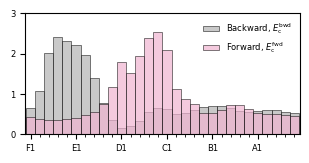

In [36]:
fig = plt.figure(figsize = (WIDTH*1.05, 1.6), dpi = 100)

ax = fig.add_subplot(1,1,1)
plt.bar(range(30), coupling_bwd, 1, lw = .5, color = "#b3b3b3ff",
                 edgecolor = "black", label = "Backward, $E_{\\rm c}^{\\rm bwd}$", alpha = .7)
plt.bar(range(30), coupling_fwd, 1, lw = .5, color = "#f0b4d1ff",
                 edgecolor = "black", label = "Forward, $E_{\\rm c}^{\\rm fwd}$", alpha = .7)

ax.set_xticks([])
ax.set_xlim(-.6, 29.6)
ax.set_yticks([0, 1, 2, 3])
ax.set_ylim(0, 3)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              ["F1", "E1", "D1", "C1", "B1", "A1"])
ax.set_ylabel("")
ax.legend(loc = "upper right")

plt.show()

# Force profile

In [37]:
force = force_per_state(traj)
force_fwd = force[0]
force_bwd = force[1]

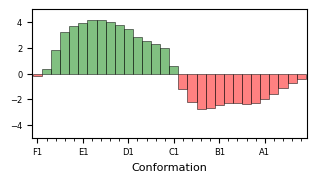

In [38]:
def color_function(x):
    colors = []
    for i in x:
        if i > 0:
            colors.append("#4ca64c")
        else:
            colors.append("#ff4c4c")
    return colors
            
fig = plt.figure(figsize = (WIDTH*1.05, 1.7), dpi = 100)

ax = fig.add_subplot(1,1,1)
net = force_bwd - force_fwd
net = net * 1.380649e-23*300 / (np.pi*12e-9/30)
# E * kT / (distance of 1/30 of a cycle)
net = net * 1e12 #(pN)


plt.bar(range(30), net, 1, lw = .5, 
        color = color_function(net),
        edgecolor = "black", alpha = .7)

ax.set_ylabel("")
ax.set_yticks(range(-4, 5,2))
ax.set_xlim(-.6, 29.6)
ax.set_ylim(-5, 5)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              ["F1", "E1", "D1", "C1", "B1", "A1"])
ax.set_xlabel("Conformation")
plt.show()

# Sum of positive and negative forces

In [39]:
np.sum(net[net > 0])

43.01931569270851

In [40]:
np.sum(net[net < 0])

-26.721645752825058